In [ ]:
%pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import re
import emoji
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from tqdm.auto import tqdm
from transformers import BertTokenizer, AutoModelForSequenceClassification, get_scheduler

import torch
from torch.utils.data import Dataset, DataLoader


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
pd.set_option('display.max_colwidth', 200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### CONFIGURATION

In [ ]:
TRAIN_DATA_PATH = '/content/train.csv'
TEST_DATA_PATH = '/content/test.csv'
SAVED_MODEL_PATH = '/content'
BERT_CHECKPOINT = 'bert-base-uncased'

MAX_LEN = 128
BATCH_SIZE = 32
NUM_CLASSES = 2
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5

print("Configuration Loaded Successfully!")


Configuration Loaded Successfully!


### DATA CLEANING : Text Preprocessing

In [ ]:
# For cleaning reviews
def clean_text(text):
    """Cleans text by removing emojis, special characters, lowercasing, stemming, and lemmatizing."""

    # Remove emojis
    text = emoji.replace_emoji(text, replace="")

    # Lowercasing
    text = text.lower()

    # Remove special symbols & extra whitespaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = " ".join(text.split())

    # Tokenization
    words = text.split()

    # Remove stopwords & apply stemming + lemmatization
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word.lower() not in stop_words]

    return " ".join(words)

In [ ]:
# Class for custom dataset
class CustomDataset(Dataset):
    def __init__(self, review, target, tokenizer, max_len, clean_text=None):
        self.clean_text = clean_text
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review)

    def __getitem__(self, idx):
        y = torch.tensor(self.target[idx], dtype=torch.long)
        X = str(self.review[idx])
        if self.clean_text:
            X = self.clean_text(X)

        encoded_X = self.tokenizer(
            X,
            return_tensors = 'pt',
            max_length = self.max_len,
            truncation=True,
            padding = 'max_length'
            )

        return {
            'input_ids': encoded_X['input_ids'].squeeze(0),
            'attention_mask': encoded_X['attention_mask'].squeeze(0),
            'labels': y
        }




# Traing loop for one epoch
def train_epoch(model, dataloader, optimizer, scheduler, device, progress_bar):

    losses = []
    accuracies = []

    model.train()
    for batch in dataloader:

        optimizer.zero_grad()
        batch = {k:v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()

        preds = torch.argmax(outputs.logits, dim=1)
        acc = torch.sum(preds == batch['labels']) / len(preds)
        accuracies.append(acc)
        losses.append(loss)

        progress_bar.update(1)

    return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()


# Evaluation loop
def eval_epoch(model, dataloader, device):
    losses = []
    accuracies = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            preds = torch.argmax(outputs.logits, dim=1)
            acc = torch.sum(preds == batch['labels']) / len(preds)
            accuracies.append(acc)
            losses.append(loss)

        return torch.tensor(losses, dtype=torch.float).mean().item(), torch.tensor(accuracies).mean().item()




# For final evaluation on test set
def test(model, dataloader, device):
    y_preds = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:

            batch = {k:v.to(device) for k, v in batch.items()}
            outputs = model(**batch)


            y_preds.extend( torch.argmax(outputs.logits, dim=1) )
            y_true.extend( batch['labels'])

        return y_preds, y_true

### LOADING AND PREPROCESSING DATA (Before Splitting)

In [ ]:
# read data and remove duplicates
data = (pd.read_csv(TRAIN_DATA_PATH).drop_duplicates())

print(f'Numbers of samples: {len(data)}')
data.head()

Numbers of samples: 374140


,text,label_text,style
0,My friend is goth and her email address is dollonesk8@yahoo.com.,formal,formality
1,"If she did not like you like that, why did she say she did? You should ask her.",formal,formality
2,You can cut out fast food restaurants for awhile.,formal,formality
3,"I am interesting in what would be best, shaving or waxing.",formal,formality
4,"In general, we do not discriminate.",formal,formality


In [ ]:
# Filter out the 'neutral' labels first
data = data[data['label_text'] != 'neutral']
data = data[data['style'] != 'formality']

# Transform targets to integers: 0 for 'very negative', 'negative' and 1 for 'very positive', 'positive'
data['label_text'] = data['label_text'].apply(
    lambda x: 0 if x in ['very negative', 'negative'] else 1
)

data.head()


<ipython-input-11-6616415d9110>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_text'] = data['label_text'].apply(


,text,label_text,style
108000,"The Rock is destined to be the 21st Century's new ""Conan"" and that he's going to make a splash even greater than Arnold Schwarzenegger, Jean-Claud Van Damme or Steven Segal.",1,sentiment
108004,"is destined to be the 21st Century's new ""Conan"" and that he's going to make a splash even greater than Arnold Schwarzenegger, Jean-Claud Van Damme or Steven Segal.",1,sentiment
108005,"is destined to be the 21st Century's new ""Conan"" and that he's going to make a splash even greater than Arnold Schwarzenegger, Jean-Claud Van Damme or Steven Segal",1,sentiment
108007,"destined to be the 21st Century's new ""Conan"" and that he's going to make a splash even greater than Arnold Schwarzenegger, Jean-Claud Van Damme or Steven Segal",1,sentiment
108025,new,1,sentiment


### DATA PREPROCESSING : Splitting Data -> Train, Validation, Test

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label_text'], random_state=20)
train_df, val_df = train_test_split(train_df, test_size=0.125, stratify=train_df['label_text'], random_state=20)

# Reset index
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Number of samples in train set: {len(train_df)}')
print(f'Number of samples in validation set: {len(val_df)}')
print(f'Number of samples in test set: {len(test_df)}')


Number of samples in train set: 54330
Number of samples in validation set: 7762
Number of samples in test set: 15524


### DATA PREPROCESSING : Tokenization & Dataloader creation

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BERT_CHECKPOINT)

dfs = {'train': train_df, 'val': val_df, 'test': test_df}
dataloaders = {}

for df in dfs:
    should_shuffle = True if df == 'train' else False
    dataloaders[df] = DataLoader(
        CustomDataset(dfs[df]['text'], dfs[df]['label_text'], tokenizer=tokenizer, max_len=MAX_LEN),
        batch_size=BATCH_SIZE, shuffle=should_shuffle
    )


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Testing if batch loads properly
for batch in dataloaders['train']:
    print({k:v.shape for k, v in batch.items()})
    break

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}


### TRAINING

In [ ]:
# SETUP

# model
model = AutoModelForSequenceClassification.from_pretrained(BERT_CHECKPOINT, num_labels=NUM_CLASSES)

model.to(device)
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

# scheduler
num_training_steps = NUM_EPOCHS * len(dataloaders['train'])
scheduler = get_scheduler(
    'linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Test
outputs = model(**{k:v.to(device) for k, v in batch.items()})
print(outputs.loss, outputs.logits.shape)

tensor(0.7392, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([32, 2])


In [ ]:
# Training, evaluation

progress_bar = tqdm(range(num_training_steps))
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc': []}

best_accuracy = 0
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, dataloaders['train'], optimizer, scheduler, device, progress_bar)
    print(f'Train Loss: {train_loss :.4f} | Accuracy: {train_acc*100 :.2f}')

    val_loss, val_acc = eval_epoch(model, dataloaders['val'], device)
    print(f'Eval Loss: {val_loss :.4f} | Accuracy: {val_acc*100 :.2f}')

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # save best model
    if val_acc > best_accuracy:
        model.save_pretrained(SAVED_MODEL_PATH)
        best_accuracy = val_acc

    print('-'*50)

  0%|          | 0/8490 [00:00<?, ?it/s]

Train Loss: 0.2312 | Accuracy: 90.76
Eval Loss: 0.1726 | Accuracy: 93.95
--------------------------------------------------
Train Loss: 0.1172 | Accuracy: 95.92
Eval Loss: 0.1741 | Accuracy: 94.25
--------------------------------------------------
Train Loss: 0.0714 | Accuracy: 97.61
Eval Loss: 0.1901 | Accuracy: 93.98
--------------------------------------------------
Train Loss: 0.0428 | Accuracy: 98.56
Eval Loss: 0.2264 | Accuracy: 94.28
--------------------------------------------------
Train Loss: 0.0263 | Accuracy: 99.13
Eval Loss: 0.2653 | Accuracy: 94.34
--------------------------------------------------


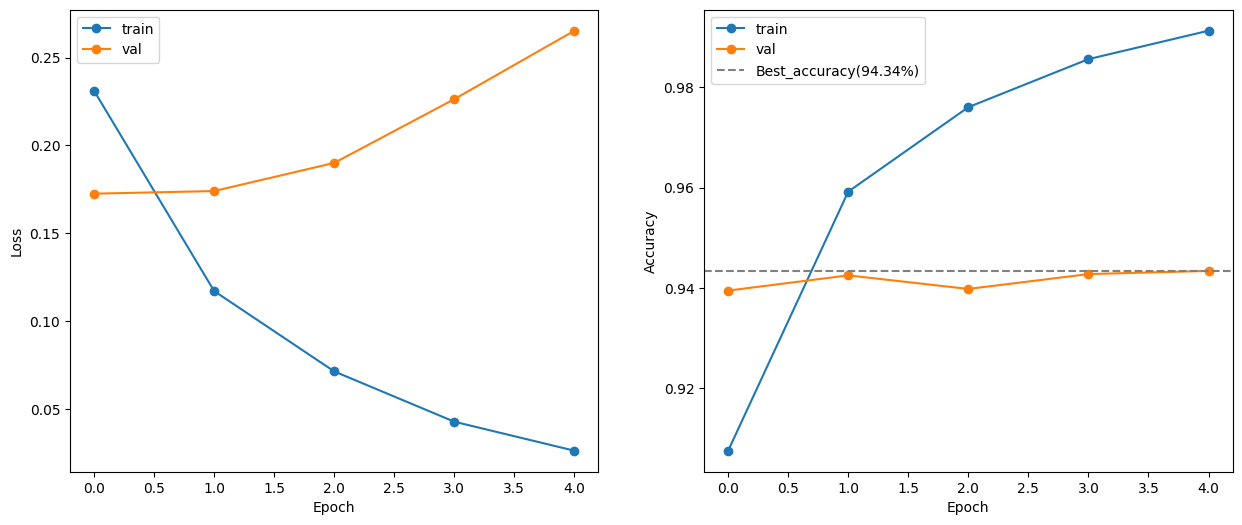

In [ ]:
# Plots
x_epochs = list(range(NUM_EPOCHS))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, history['train_loss'], marker='o', label='train')
plt.plot(x_epochs, history['val_loss'], marker='o', label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, history['train_acc'], marker='o', label='train')
plt.plot(x_epochs, history['val_acc'], marker='o', label='val')
plt.axhline(best_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({best_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### TEST

In [ ]:
y_preds, y_true = test(model,dataloaders['test'], device)

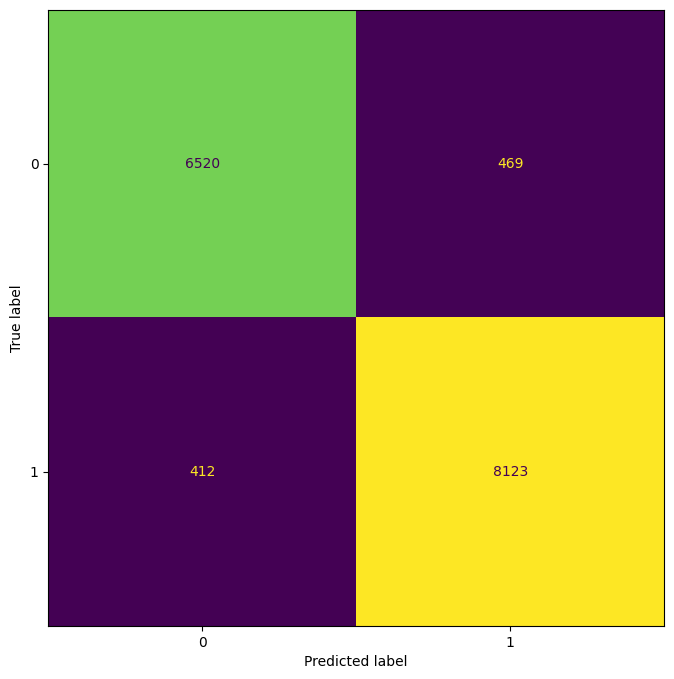

In [ ]:
_ , ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(torch.tensor(y_true), torch.tensor(y_preds), ax = ax, colorbar = False);

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Convert list of tensors to a single tensor
# y_true = torch.stack(y_true).cpu().numpy()
# y_preds = torch.stack(y_preds).cpu().numpy()

print(classification_report(y_true, y_preds))


              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6989
           1       0.95      0.95      0.95      8535

    accuracy                           0.94     15524
   macro avg       0.94      0.94      0.94     15524
weighted avg       0.94      0.94      0.94     15524



In [ ]:
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define source and destination paths
source_path = "/content/model.safetensors"
destination_path = "/content/drive/MyDrive/model.safetensors"  # Change path if needed

# Check and move the file
if os.path.exists(source_path):
    shutil.move(source_path, destination_path)
    print(f"model.safetensors moved to: {destination_path}")
else:
    print("model.safetensors not found.")


Mounted at /content/drive
model.safetensors moved to: /content/drive/MyDrive/model.safetensors
